## Using Regression Analysis to Test the "Hot Hand"

In this section, we will use regression analysis to test for the "hot hand."

#### Import useful libraries and the shot log data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Shotlog=pd.read_csv("../../Data/Week 6/Shotlog2.csv")
# Player_Stats=pd.read_csv("../../Data/Week 6/Player_Stats2.csv")
# Player_Shots=pd.read_csv("../../Data/Week 6/Player_Shots2.csv")

Shotlog=pd.read_csv("/content/Shotlog2.csv")
Player_Stats=pd.read_csv("/content/Player_Stats2.csv")
Player_Shots=pd.read_csv("/content/Player_Shots2.csv")

Shotlog.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,shoot_player,time_from_last_shot,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit
0,MISSED,PG,Yes,210.0,SCORED,ATL,Pullup Jump Shot,2.0,WAS,267.0,...,Dennis Schroder,27.0,1.0,MISSED,0.0,1.0,0.451029,1215.0,12.0,0.0
1,MISSED,SF,Yes,279.0,SCORED,ATL,Jump Shot,3.0,WAS,130.0,...,Kent Bazemore,4.0,1.0,MISSED,0.0,0.0,0.408587,722.0,7.0,0.0
2,MISSED,PG,Yes,58.0,SCORED,ATL,Driving Layup,2.0,WAS,262.0,...,Dennis Schroder,50.0,1.0,MISSED,0.0,0.0,0.451029,1215.0,12.0,0.0
3,MISSED,C,Yes,107.0,SCORED,ATL,Turnaround Jump Shot,2.0,WAS,254.0,...,Dwight Howard,3.0,1.0,MISSED,0.0,1.0,0.631922,614.0,9.0,0.0
4,MISSED,PF,Yes,167.0,MISSED,ATL,Pullup Jump Shot,2.0,WAS,306.0,...,Paul Millsap,47.0,1.0,SCORED,1.0,0.0,0.442387,972.0,20.0,0.0


### Prediction Error
Let's create a variable that equals to the difference between the outcome of the shot and the average success rate. Since we typically use the average success rate to predict the outcome of the shot, this difference will capture the prediction error.

In [2]:
Shotlog['error']=Shotlog['current_shot_hit']-Shotlog['average_hit']
Shotlog['lagerror']=Shotlog['lag_shot_hit']-Shotlog['average_hit']

We can graph the outcome of the shots to see if there is any pattern over time in the variable.

We will look at LeBron James' performance during the regular season as an example.

In [3]:
Shotlog['time'] = pd.to_timedelta(Shotlog['time'])
Shotlog['time'].describe()

,time
count,47933
mean,0 days 00:06:19.258360628
std,0 days 00:03:23.341059878
min,0 days 00:00:00
25%,0 days 00:03:28
50%,0 days 00:06:17
75%,0 days 00:09:14
max,0 days 00:12:00


We will first graph the outcome of LeBron James' shots in a single game on April 9th, 2017.

(To make this graph, we use a small trick. Instead of asking Python to produce a scatter plot with the "plot.scatter" command, we ask Python to graph a line plot, but specify the width of the line to be 0. So essentially we produce a scatter plot. The reason we do it this way is because in Python, scatter plot requires the x axis to be numeric. It does not allow scatter plot where the x axis is a date or time variable.)

<Axes: xlabel='time'>

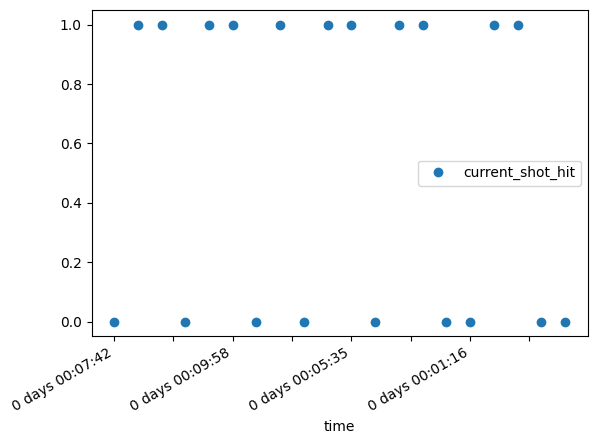

In [4]:
Shotlog[(Shotlog.shoot_player == 'LeBron James')&(Shotlog.date=='2017-04-09')].plot(x='time', y='current_shot_hit', marker='o', linewidth=0)

Let's create a graph of the outcomes of individual shots for Lebron James throughout the regular season. We will create a subgraph for each game he played.


We will first subset a dataset that includes only LeBron James' data.

In [5]:
LeBron_James=Shotlog[(Shotlog.shoot_player == 'LeBron James')]
LeBron_James.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror
30762,MISSED,SF,Yes,236.0,MISSED,CLE,Jump Shot,3.0,NYK,84.0,...,1.0,MISSED,0.0,1.0,0.547619,1344.0,14.0,0.0,-0.547619,0.452381
30763,BLOCKED,SF,Yes,264.0,SCORED,CLE,Jump Shot,3.0,NYK,383.0,...,1.0,MISSED,0.0,0.0,0.547619,1344.0,14.0,0.0,-0.547619,-0.547619
30770,SCORED,SF,Yes,50.0,MISSED,CLE,Running Layup,2.0,NYK,259.0,...,1.0,SCORED,1.0,0.0,0.547619,1344.0,14.0,0.0,0.452381,-0.547619
30776,MISSED,SF,Yes,52.0,SCORED,CLE,Putback Dunk,2.0,NYK,250.0,...,1.0,SCORED,1.0,1.0,0.547619,1344.0,14.0,1.0,0.452381,0.452381
30784,MISSED,SF,Yes,52.0,MISSED,CLE,Dunk,2.0,NYK,250.0,...,2.0,SCORED,1.0,1.0,0.547619,1344.0,14.0,1.0,0.452381,0.452381


Now we can graph prediction error for LeBron James for all the games separately in the season.

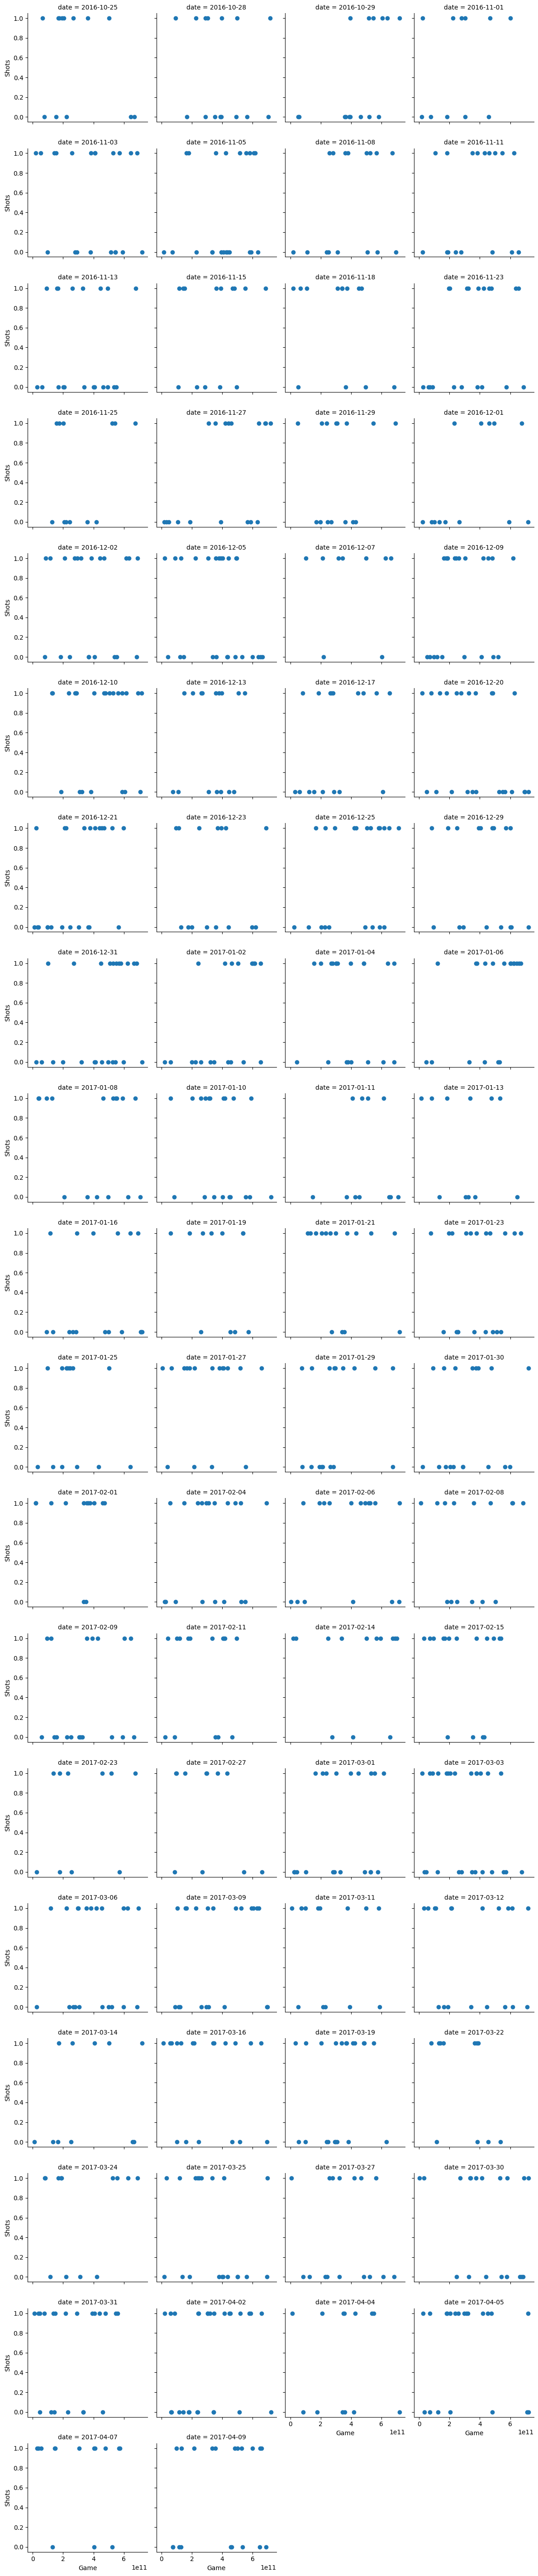

In [6]:
g = sns.FacetGrid(LeBron_James, col="date", col_wrap=4)
g = g.map(plt.plot, "time", "current_shot_hit", marker='o', linewidth=0)
g.set_axis_labels("Game", "Shots");

We will do a similar exercise for the statistics of Cheick Diallo.


In [8]:
Cheick_Diallo=Shotlog[(Shotlog.shoot_player == 'Cheick Diallo')]
Cheick_Diallo.head() # 0 rows, thus ValueError below

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror


In [9]:
g = sns.FacetGrid(Cheick_Diallo, col="date", col_wrap=4)
g = g.map(plt.plot, "time", "current_shot_hit", marker='o', linewidth=0)
g.set_axis_labels("Game", "Shots");

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x0 with 0 Axes>

## Self Test - 1
### Graph the prediction error for James Jones
- Separate the shots by game
- Interpret your result

In [10]:
#Your Code Here
James_Jones=Shotlog[(Shotlog.shoot_player == 'James Jones')]
James_Jones.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror
30836,MISSED,SF,Yes,740.0,SCORED,CLE,Jump Shot,2.0,NYK,415.0,...,4.0,MISSED,0.0,1.0,0.47,100.0,2.0,0.0,-0.47,0.53
31678,SCORED,SF,Yes,789.0,MISSED,CLE,Jump Shot,3.0,DET,17.0,...,4.0,MISSED,0.0,1.0,0.47,100.0,2.0,0.0,-0.47,0.53
31836,SCORED,SF,Yes,666.0,MISSED,CLE,Jump Shot,3.0,DAL,365.0,...,4.0,SCORED,1.0,1.0,0.47,100.0,3.0,1.0,0.53,0.53
31839,SCORED,SF,Yes,887.0,SCORED,CLE,Jump Shot,3.0,DAL,488.0,...,4.0,SCORED,1.0,1.0,0.47,100.0,3.0,1.0,0.53,0.53
31897,SCORED,SF,No,54.0,MISSED,PHI,Jump Shot,3.0,CLE,472.0,...,3.0,SCORED,1.0,1.0,0.47,100.0,2.0,1.0,0.53,0.53


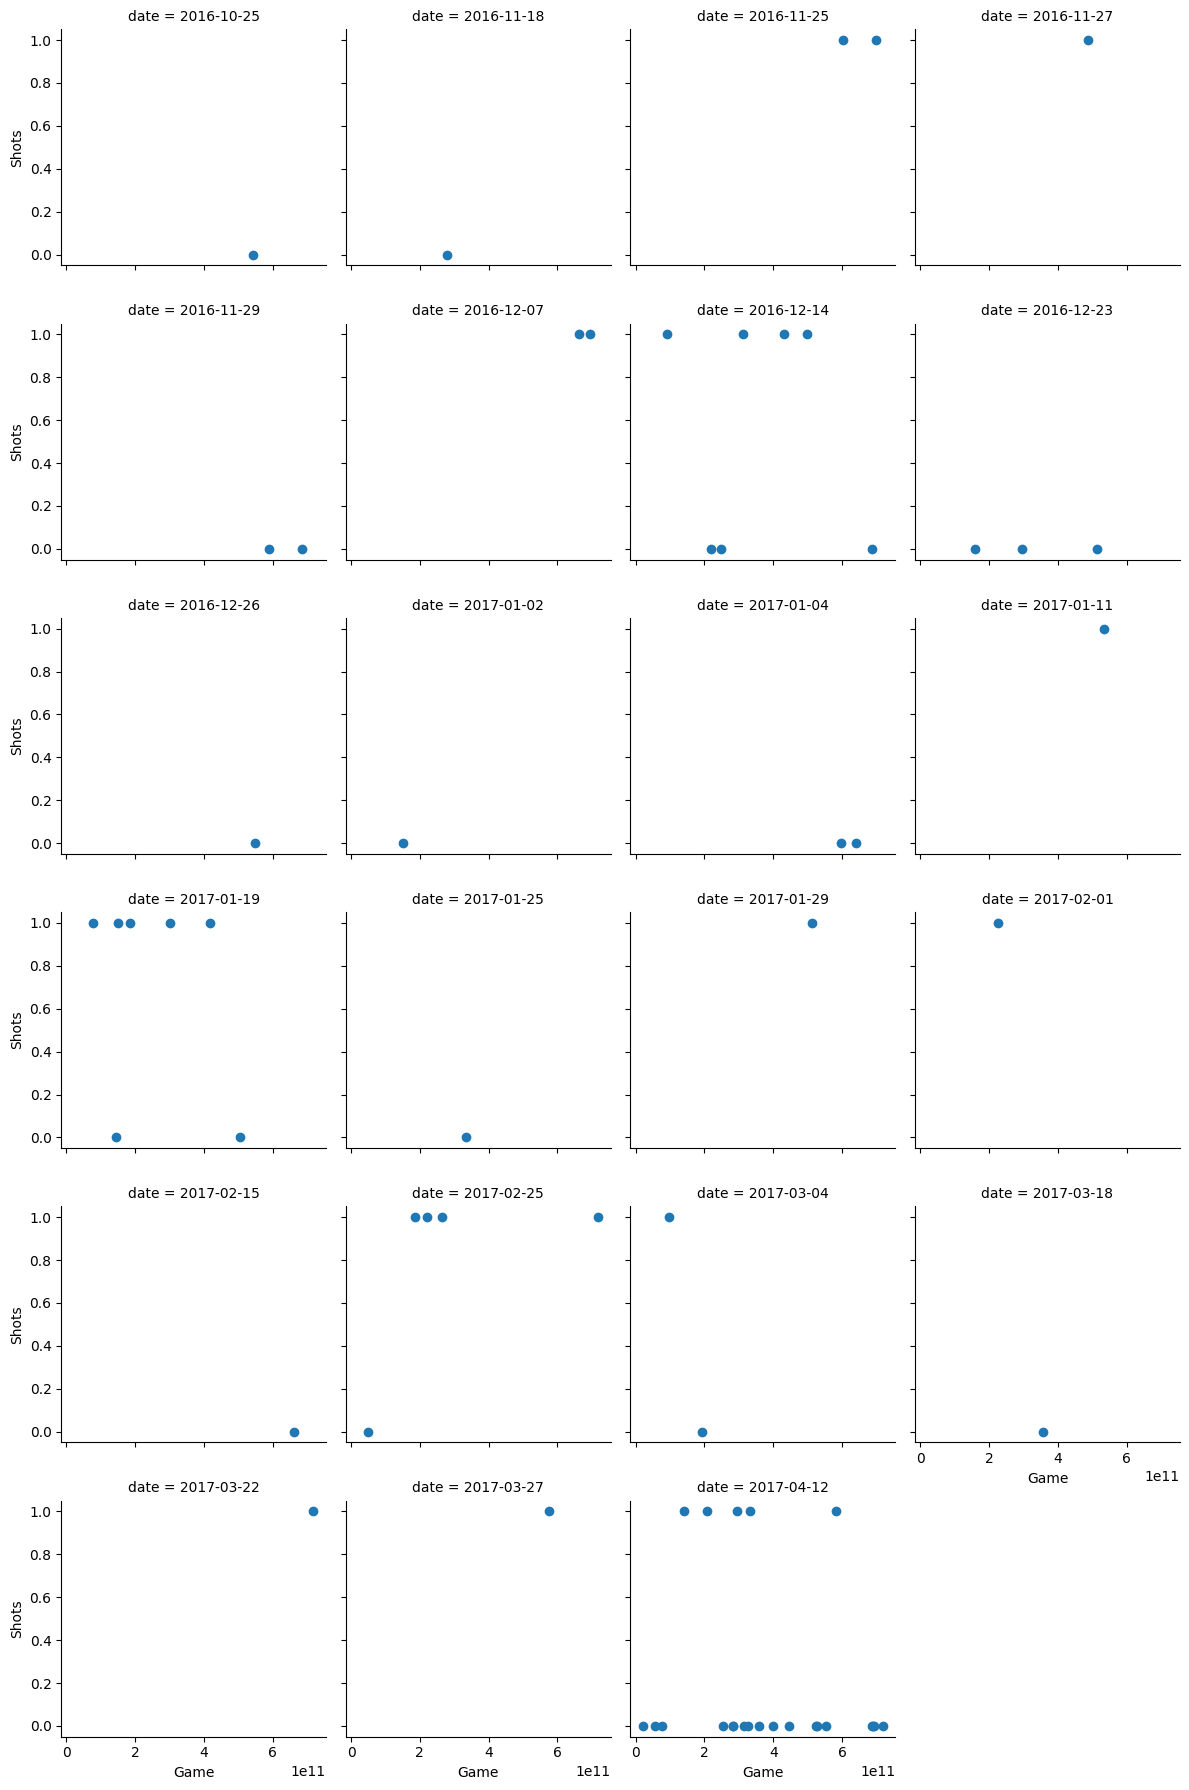

In [11]:
g = sns.FacetGrid(James_Jones, col="date", col_wrap=4)
g = g.map(plt.plot, "time", "current_shot_hit", marker='o', linewidth=0)
g.set_axis_labels("Game", "Shots");

### Regression analysis on prediction error
We will first run a simple regression of the prediction error of current period on the prediction error of previous period.

In [12]:
reg1 = sm.ols(formula = 'error ~ lagerror', data= Shotlog).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.45
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           9.68e-08
Time:                        18:45:19   Log-Likelihood:                -34265.
No. Observations:               47932   AIC:                         6.853e+04
Df Residuals:                   47930   BIC:                         6.855e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0016      0.002      0.707      0.4

_The estimated coefficient of the lagged error is statistically significant. However, the R-Squared for this regression is also zero. This means that our specified linear model is not a good fit for our data at all!_

There are a lot of factors that may influence the success of shot, for example, the player’s own skill as a shooter, the type of the shot, the atmosphere of the stadium (whether it is home or away game), and whether it is at the beginning or towards the end of the game. Let’s add these control variables in our regression.

In [13]:
reg2 = sm.ols(formula = 'error ~ lagerror+player_position+home_game+opponent_previous_shot+C(points)+time_from_last_shot+C(quarter)', data= Shotlog).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     40.87
Date:                Wed, 18 Dec 2024   Prob (F-statistic):          4.48e-151
Time:                        18:45:27   Log-Likelihood:                -32628.
No. Observations:               46156   AIC:                         6.530e+04
Df Residuals:                   46136   BIC:                         6.547e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

_We can see that the R-squared is now increased to 0.015 which is still very small. The estimate on lagerror is statistically significant, but the magnitude of the estimate is -0.0136 which is still very small. And it is negative, meaning that the success of the previous shot would hurt the chance of the subsequent shot. This is contrary to what the hot hand predicts._  

### Weighted least squares regression
As we have seen, some players had a lot of shot per game while some just had a few. Different players may have different variations in their success rate in the shots. We can run a weighted least squared regression to address this problem.

Weighted least squares estimation weights the observations proportional to the reciprocal of the error variance of the observation. Thus weighted least squares can overcome the issue of non-constant variance.

#### We can use the “sm.wls” command to run the weighted least square regression weighted by the number of shot per game (weight=1/shot_per_game).

In [14]:
reg3 = sm.wls(formula = 'error ~ lagerror+player_position+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/Shotlog['shot_per_game'], data=Shotlog).fit()
print(reg3.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.018
Model:                            WLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     64.35
Date:                Wed, 18 Dec 2024   Prob (F-statistic):          7.98e-169
Time:                        18:45:47   Log-Likelihood:                -35801.
No. Observations:               46156   AIC:                         7.163e+04
Df Residuals:                   46142   BIC:                         7.175e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

From our summary statistics, some players exhibit a stream of the success while some don’t. In our previous regressions, we are grouping all the players together. Let’s see if we can find any effect if we look at individual players.

#### Regression analysis on individual players

Run a regression of current error on lagged error for LeBron James.

In [15]:
reg_LeBron = sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+C(points)+time_from_last_shot+C(quarter)', data=LeBron_James).fit()
print(reg_LeBron.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     6.937
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           1.89e-11
Time:                        18:45:58   Log-Likelihood:                -827.33
No. Observations:                1204   AIC:                             1679.
Df Residuals:                    1192   BIC:                             1740.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Similarly, we can run a weighted least squares estimation on LeBron James’ prediction error, weighted by the number of shot he made in each game.

In [16]:
reg_LeBron_wls = sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/LeBron_James['shot_per_game'], data=LeBron_James).fit()
print(reg_LeBron_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.066
Model:                            WLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     12.15
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           4.63e-15
Time:                        18:46:34   Log-Likelihood:                -837.48
No. Observations:                1204   AIC:                             1691.
Df Residuals:                    1196   BIC:                             1732.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

We can also take a look back at LeBron James’ autocorrelation coefficient.

In [17]:
Shotlog[(Shotlog.shoot_player == 'LeBron James')][['current_shot_hit','lag_shot_hit']].corr()

,current_shot_hit,lag_shot_hit
current_shot_hit,1.000000,-0.033244
lag_shot_hit,-0.033244,1.000000


_The autocorrelation coefficient between the outcomes of the current shot and the previous shot for LeBron James is very small._

We can do a similar exercise for James Jones. We will start with an ordinary least square regression.

In [18]:
reg_Jones = sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+C(points)+time_from_last_shot+C(quarter)', data= James_Jones).fit()
print(reg_Jones.summary())

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.7016
Date:                Wed, 18 Dec 2024   Prob (F-statistic):              0.705
Time:                        18:46:51   Log-Likelihood:                -43.888
No. Observations:                  66   AIC:                             107.8
Df Residuals:                      56   BIC:                             129.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

We will also run a weighted least squares estimation on Jones' statistics. Weight=1/shot_per_game.

In [19]:
reg_Jones_wls = sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/James_Jones['shot_per_game'], data= James_Jones).fit()
print(reg_Jones_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.213
Model:                            WLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.244
Date:                Wed, 18 Dec 2024   Prob (F-statistic):             0.0433
Time:                        18:47:10   Log-Likelihood:                -53.746
No. Observations:                  66   AIC:                             123.5
Df Residuals:                      58   BIC:                             141.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Self Test - 2

Use regression analysis to test "hot hand" for Cheick Diallo
1. Run an ordinary least square regression of current error on lagged error for Cheick Diallo.
2. Run a weighted least sqaure regression of current error on lagged error for Cheick Diallo, weight=1/shot_per_game.
3. Interpret your regression results.

In [20]:
#Your Code Here
reg_Diallo = sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', data=Cheick_Diallo).fit()
print(reg_Diallo.summary()) # See above

ValueError: negative dimensions are not allowed

In [21]:
# Testing "hot hand" for James_Jones instead
reg_Jones = sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', data=James_Jones).fit()
print(reg_Jones.summary()) # See above

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.8413
Date:                Wed, 18 Dec 2024   Prob (F-statistic):              0.558
Time:                        18:53:59   Log-Likelihood:                -44.223
No. Observations:                  66   AIC:                             104.4
Df Residuals:                      58   BIC:                             122.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [22]:
#Your Code Here
reg_Jones_wls = sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/James_Jones['shot_per_game'], data=James_Jones).fit()
print(reg_Jones_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.213
Model:                            WLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.244
Date:                Wed, 18 Dec 2024   Prob (F-statistic):             0.0433
Time:                        18:54:19   Log-Likelihood:                -53.746
No. Observations:                  66   AIC:                             123.5
Df Residuals:                      58   BIC:                             141.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

#### More generally, we can define functions to run regressions for each individual player.

- Define a function to run ordinary least square regression by player.

In [23]:
def reg_player(player):
    Shotlog_player=Shotlog[Shotlog.shoot_player==player]
    reg_player=sm.ols(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', data= Shotlog_player).fit()
    print(reg_player.summary())
    return;

We can then use this function for individual player, for example, Russell Westbrook.

In [24]:
reg_player('Russell Westbrook')

ValueError: negative dimensions are not allowed

In [25]:
Russell_Westbrook=Shotlog[(Shotlog.shoot_player == 'Russell Westbrook')]
Russell_Westbrook.head()

,team_previous_shot,player_position,home_game,location_x,opponent_previous_shot,home_team,shot_type,points,away_team,location_y,...,quarter,current_shot_outcome,current_shot_hit,lag_shot_hit,average_hit,shot_count,shot_per_game,conse_shot_hit,error,lagerror


- Define a function to run weighted least square regression by player.

In [26]:
def reg_wls_player(player):
    Shotlog_player=Shotlog[Shotlog.shoot_player==player]
    reg_wls_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/Shotlog_player['shot_per_game'], data=Shotlog_player).fit()
    print(reg_wls_player.summary())
    return;

Let's use this function to run a weighted least squares estimation for Russell Westbrook.

In [ ]:
# reg_wls_player('Russell Westbrook')

In [27]:
# Testing it for James_Jones instead
reg_wls_player('James Jones')

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.213
Model:                            WLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.244
Date:                Wed, 18 Dec 2024   Prob (F-statistic):             0.0433
Time:                        18:58:30   Log-Likelihood:                -53.746
No. Observations:                  66   AIC:                             123.5
Df Residuals:                      58   BIC:                             141.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

#### We can extract estimated coefficient on the lagged error for each player.
- Create a list of unique player names

In [28]:
player_list = np.array(Shotlog['shoot_player'])
player_list = np.unique(player_list)

In [29]:
player_list[0]

'A.J. Hammons'

- Run weighted least squares regression for each player by specifying "shoot_play==player_list[index]"

In [30]:
Shotlog_player=Shotlog[Shotlog.shoot_player==player_list[0]]
reg_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/Shotlog_player['shot_per_game'], data=Shotlog_player).fit()
print(reg_player.summary())

                            WLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.410
Model:                            WLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     2.317
Date:                Wed, 18 Dec 2024   Prob (F-statistic):             0.0732
Time:                        18:58:59   Log-Likelihood:                -12.596
No. Observations:                  27   AIC:                             39.19
Df Residuals:                      20   BIC:                             48.26
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

- Extract the estimated coefficients, along with the p-value and t-statistics of the estimates and store them in a dataframe

In [31]:
RegParams = pd.DataFrame(reg_player.params).reset_index()
RegTvals = pd.DataFrame(reg_player.tvalues).reset_index()
RegPvals = pd.DataFrame(reg_player.pvalues).reset_index()

RegOutput = pd.merge(RegParams, RegTvals, on=['index'])
RegOutput = pd.merge(RegOutput, RegPvals, on=['index'])
RegOutput

,index,0_x,0_y,0
0,Intercept,0.274644,0.356938,0.724877
1,home_game[T.Yes],-0.302603,-1.475049,0.155769
2,opponent_previous_shot[T.SCORED],-0.570258,-2.292908,0.032826
3,lagerror,0.090024,0.432869,0.669742
4,points,-0.152748,-0.629826,0.535938
5,time_from_last_shot,-0.003295,-0.446319,0.660162
6,quarter,0.164321,1.538863,0.139510


- Write a loop to extract regression outputs for each player

In [32]:
i = 0
Player_Results = {}
while i <= len(player_list) - 1:
    Shotlog_player=Shotlog[Shotlog.shoot_player==player_list[i]]
    reg_player=sm.wls(formula = 'error ~ lagerror+home_game+opponent_previous_shot+points+time_from_last_shot+quarter', weights=1/Shotlog_player['shot_per_game'], data=Shotlog_player).fit()
    RegParams = pd.DataFrame(reg_player.params).reset_index()
    RegTvals = pd.DataFrame(reg_player.tvalues).reset_index()
    RegPvals = pd.DataFrame(reg_player.pvalues).reset_index()

    RegOutput = pd.merge(RegParams, RegTvals, on=['index'])
    RegOutput = pd.merge(RegOutput, RegPvals, on=['index'])
    RegOutput

    LagErr = RegOutput[RegOutput['index'] == 'lagerror']
    LagErr = LagErr.drop(columns=['index'])
    LagErr = LagErr.rename(columns={"0_x":"Coef", "0_y":"T_Statistics", 0:"P_Value"})
    LagErr['shoot_player'] = player_list[i]
    Headers = ['shoot_player', 'Coef', 'T_Statistics', 'P_Value']
    Player_Results[i] = LagErr[Headers]
    i = i+1

- Write another loop to build a dataframe to store the regression output for all the players

In [36]:
RegPlayer = Player_Results[0]
j = 1
while j <= len(player_list) - 1:
    # RegPlayer = RegPlayer.append(Player_Results[j]) # https://stackoverflow.com/questions/75956209/error-dataframe-object-has-no-attribute-append
    RegPlayer = RegPlayer._append(Player_Results[j])
    j = j+1
RegPlayer = RegPlayer.reset_index()
RegPlayer = RegPlayer.drop(columns=['index'])
RegPlayer

,shoot_player,Coef,T_Statistics,P_Value
0,A.J. Hammons,0.090024,0.432869,0.669742
1,Al Horford,-0.031727,-0.851036,0.395038
2,Alonzo Gee,0.594937,0.000000,NaN
3,Amir Johnson,0.107613,1.835580,0.067515
4,Andrew Bogut,0.065470,0.416692,0.678842
...,...,...,...,...
138,Walter Tavares,0.003626,0.000000,NaN
139,Wesley Matthews,-0.084057,-2.320181,0.020599
140,Will Barton,-0.031413,-0.695883,0.486838
141,Wilson Chandler,-0.020968,-0.570989,0.568185


- Merge the total number of shots captured in "Player_Shots" to the regression result dataframe. This total number of shots represents the sample size of each regression

In [37]:
RegPlayer=pd.merge(RegPlayer, Player_Shots, on=['shoot_player'])
RegPlayer.head()

,shoot_player,Coef,T_Statistics,P_Value,shot_count,avg_shot_game
0,A.J. Hammons,0.090024,0.432869,0.669742,42,2.800000
1,Al Horford,-0.031727,-0.851036,0.395038,801,11.779412
2,Alonzo Gee,0.594937,0.000000,NaN,14,2.000000
3,Amir Johnson,0.107613,1.835580,0.067515,369,4.670886
4,Andrew Bogut,0.065470,0.416692,0.678842,81,3.521739


- Display players with statistically significant estimates on the lagged error variable

In [38]:
display(RegPlayer.loc[RegPlayer['P_Value']<=0.05])

,shoot_player,Coef,T_Statistics,P_Value,shot_count,avg_shot_game
26,DeAndre Liggins,-0.257574,-2.468259e+00,1.558089e-02,142,3.021277
42,Frank Kaminsky,0.086975,2.306844e+00,2.136766e-02,802,10.693333
50,Isaiah Thomas,-0.073223,-2.697235e+00,7.078367e-03,1473,19.381579
65,Joe Harris,-0.150670,-2.631296e+00,8.954691e-03,362,6.961538
74,Justin Anderson,-0.132530,-1.976239e+00,4.944939e-02,436,6.228571
83,Kevin Love,-0.077740,-2.164096e+00,3.076020e-02,867,14.450000
85,Kyle Korver,-0.134847,-2.795064e+00,5.426807e-03,514,7.671642
101,Mike Miller,0.033333,2.820409e+12,2.257189e-13,23,2.300000
110,Nikola Mirotic,-0.091055,-2.157452e+00,3.142518e-02,624,8.914286
115,Quinn Cook,-0.496887,-2.602419e+00,2.312255e-02,65,5.416667


_There are a total of 38 players with statistically significant estimates on the lagged error variable, that is, the success of their previous shots impact the success rate of their current shot. Interestingly, more than half of these estimates are negative, which means that a success in the previous shot actually hurts the chance of scoring in the current shot. This is the opposite of a "hot hand."_

_Overall from our regression analyses, 8 players, Boris Diaw, Brandon Rush, Frank Kaminsky, Joe Young, Jose Calderon, Kyle Wiltjer, Omri Casspi, Robert Covington, and Tony Parker have positive and statistically significant estimate on the lagged error variable. Thus, these players may have "hot hand." Note that the estimate for Kyle Wiltjer is 1 and there are only a total of 14 observations for him. We need to interpret his result with caution._

In [39]:
# # Save updated data to csv file
# Shotlog.to_csv("../../Data/Week 6/Shotlog3.csv")
# Player_Stats.to_csv("../../Data/Week 6/Player_Stats3.csv", index=False)
# Player_Shots.to_csv("../../Data/Week 6/Player_Shots3.csv", index=False)

Shotlog.to_csv("/content/Shotlog3.csv")
Player_Stats.to_csv("/content/Player_Stats3.csv", index=False)
Player_Shots.to_csv("/content/Player_Shots3.csv", index=False)